In [ ]:
#https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#libraries
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

pd.options.display.float_format = '{:20,.4f}'.format

#my libraries
from wrangle import get_connection, get_zillow_data, handle_missing_values, remove_columns, wrangle_zillow, remove_outliers, train_validate_test_split, get_hist, get_box
from explore import explore_univariate, exp_bivariate_categorical, exp_bivariate_continuous, exp_multivariate, exp_bivariate_categorical
import env

#library imports
from datetime import date
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

In [2]:
df = get_zillow_data()
df.head(2)

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,id,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,261.0000,NaN,NaN,NaN,NaN,1727539,NaN,...,0,0.0256,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,261.0000,NaN,NaN,NaN,NaN,1387261,NaN,...,1,0.0556,2017-01-01,None,None,None,None,Single Family Residential,None,None


In [3]:
df = wrangle_zillow(df)
df.head(2)

,bathrooms,bedrooms,sqft,latitude,longitude,lot_size,tax_value,logerror,county,age,tax_rate,price_per_sqft
0,3,4,3100,"33,634,931.0000","-117,869,207.0000",4506,1023282,0.0256,Orange,23,0.0108,330
1,1,2,1465,"34,449,266.0000","-119,281,531.0000",12647,464000,0.0556,Ventura,54,0.0122,316


In [4]:
train, validate, test = train_validate_test_split(df)
print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  479520
validate observations:  205524
test observations:  171264


# Explore
- We are not going to explore the scaled data at this time, but it is important that the data is scaled before moving into clustering.

- Target Variable: 'log_error'

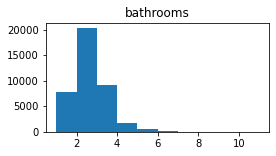

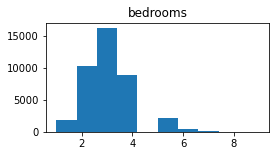

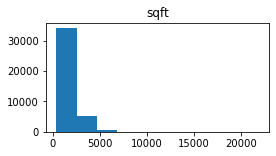

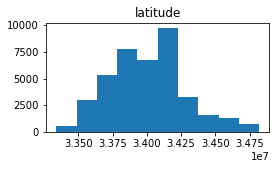

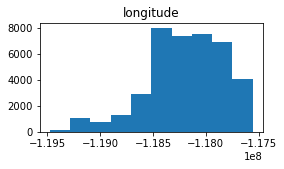

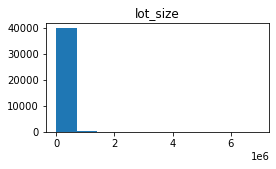

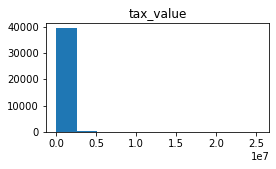

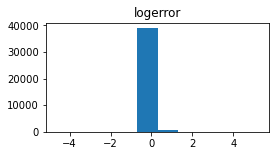

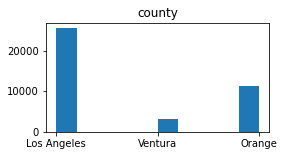

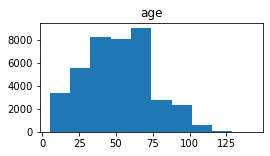

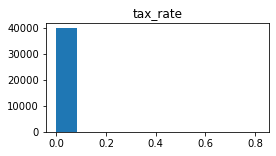

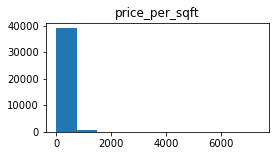

In [5]:
#What are the distributions of each variable (train)
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

##### Takeawyas
- right skewed tax_value, square_feet, and tax_rate
- bit of a left skew on age
- log_error normally distributed

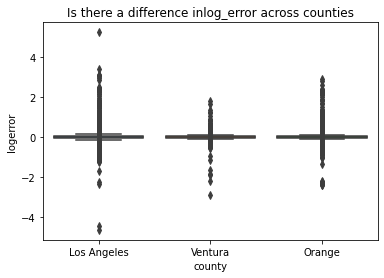

In [7]:
#Does log error differ across counties?
sns.boxplot(train.county, train.logerror)
plt.title("Is there a difference inlog_error across counties")
plt.show()

Is there a relationship between log_error and bathrooms?


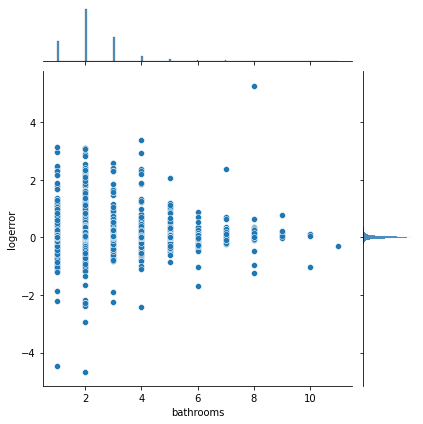

In [8]:
#Is there a relationship between log_error and bathrooms?
print("Is there a relationship between log_error and bathrooms?")
sns.jointplot(x = 'bathrooms', y = 'logerror', data=train)
plt.xlabel("Bathrooms")
plt.ylabel("Log Error")
plt.show()

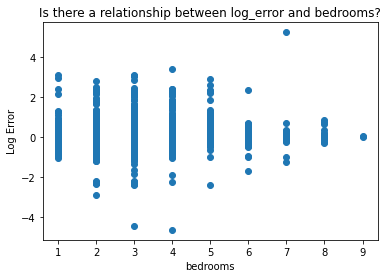

In [9]:
#Is there a relationship between log_error and bedrooms?
# plot age by spending_score
plt.scatter(train.bedrooms, train.logerror)
plt.xlabel("bedrooms")
plt.ylabel("Log Error")
plt.title("Is there a relationship between log_error and bedrooms?")
plt.show()

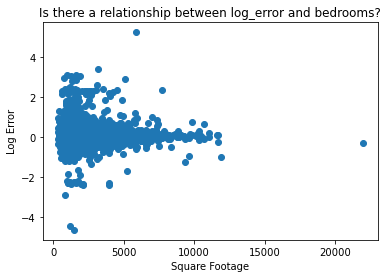

In [10]:
#Is there a relationship between log_error and square feet?
plt.scatter(train.sqft, train.logerror)
plt.xlabel("Square Footage")
plt.ylabel("Log Error")
plt.title("Is there a relationship between log_error and bedrooms?")
plt.show()

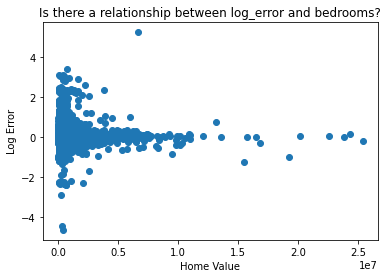

In [11]:
#Is there a relationship between log_error and tax_value?
plt.scatter(train.tax_value, train.logerror)
plt.xlabel("Home Value")
plt.ylabel("Log Error")
plt.title("Is there a relationship between log_error and bedrooms?")
plt.show()